# Exploring `pytorch-lightning` with `xaitk-saliency` Integration

This example extends the "PyTorch Lightning DataModules" notebook, found [here](https://github.com/Lightning-AI/tutorials/blob/publication/.notebooks/lightning_examples/datamodules.ipynb), for multi-GPU based training. Additionally, this notebook will explore integrating `xaitk-saliency` and `pytorch-lightning` to generate saliency maps for model predictions.

## Table of Contents

* [Environment Setup](#environment-setup)
* [Imports](#imports)
* [Model Preparation](#model-preparation)
  * [Defining the Dataset Agnostic `LitModel`](#defining-dataset-agnostic-lit-model)
  * [Defining the `CIFAR10DataModule`](#defining-cifar10-data-module)
  * [Training `LitModel` Using the `CIFAR10DataModule`](#training-lit-model-for-cifar10)
* [`xaitk-saliency` Integration](#xaitk-integration)
  * [High-Level API Integration](#high-level-api-integration)
    * [Defining the "Application"](#defining-the-application)
    * [Black-Box Classifier](#black-box-classifier)
    * [Saliency Generator](#saliency-generator)
    * [Calling the Application](#calling-the-application)
  * [Low-Level API Integration](#low-level-api-integration)
    * [Defining `LitSaliencyModel`](#defining-lit-saliency-model)
    * [Perturber and Saliency Generator](#perturber-and-saliency-generator)
    * [Saliency Generator](#saliency-generator)
    * [Generate Saliency Maps](#generate-saliency-maps)
  * [Results Comparison](#results-comparison)

## Environment Setup <a name="environment-setup"></a>

In [1]:
import sys
!{sys.executable} -m pip install -qU pip
print("Installing torchmetrics...")
!{sys.executable} -m pip install -q 'torchmetrics>=0.7'
print("Installing ipython...")
!{sys.executable} -m pip install -q ipython[notebook]
print("Installing setuptools...")
!{sys.executable} -m pip install -q setuptools
print("Installing torch...")
!{sys.executable} -m pip install -q 'torch>=1.8'
print("Installing pytorch-lightning...")
!{sys.executable} -m pip install -q 'pytorch-lightning>=1.6,<2.0'
print("Installing torchvision...")
!{sys.executable} -m pip install -q torchvision
print("Installing xaitk-saliency...")
!{sys.executable} -m pip install -q xaitk-saliency
print("Done!")

Installing torchmetrics...
Installing ipython...
Installing setuptools...
Installing torch...
Installing pytorch-lightning...
Installing torchvision...
Installing xaitk-saliency...
Done!


## Imports <a name="imports"></a>

In [2]:
import os

import torch
import torch.nn.functional as F
from pytorch_lightning import Callback, LightningDataModule, LightningModule, Trainer
from pytorch_lightning.accelerators.accelerator import Accelerator
from pytorch_lightning.callbacks.progress.tqdm_progress import TQDMProgressBar
from torch import nn
from torch.utils.data import Dataset, IterableDataset, DataLoader, random_split, get_worker_info
from torchmetrics.functional import accuracy
from torchvision import transforms

# Note you must have torchvision installed for this example
from torchvision.datasets import CIFAR10

# xaitk-saliency integration imports
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Dict, Hashable, Iterable, Optional, Sequence, Tuple, Union
# High-Level
from smqtk_classifier.interfaces.classify_image import ClassifyImage
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack
from xaitk_saliency.interfaces.gen_image_classifier_blackbox_sal import GenerateImageClassifierBlackboxSaliency
# Low-Level
from xaitk_saliency.interfaces.perturb_image import PerturbImage
from xaitk_saliency.utils.masking import occlude_image_streaming, occlude_image_batch
from xaitk_saliency.impls.gen_classifier_conf_sal.occlusion_scoring import OcclusionScoring
from xaitk_saliency.interfaces.gen_classifier_conf_sal import GenerateClassifierConfidenceSaliency
from xaitk_saliency.impls.perturb_image.sliding_window import SlidingWindow

# For "artifact tracking" (to compare results)
import pickle

In [3]:
from lightning_fabric.utilities.seed import seed_everything

# For reproducability
seed_everything(0, workers = True)

Global seed set to 0


0

## Model Preparation <a name="model-preparation"></a>

### Defining the Dataset Agnostic `LitModel` <a name="defining-dataset-agnostic-lit-model"></a>

Below we define the same `LitMNIST` model as was defined in [PyTorch Lightning's MNIST Hello World Notebook](https://github.com/Lightning-AI/tutorials/blob/publication/.notebooks/lightning_examples/mnist-hello-world.ipynb). However, we'll modify it to be data agnostic so we can use any input data we'd like. We'll also make some slight modifications to the model to ensure our model can scale without changes, as noted in [Lightning's documentation](https://pytorch-lightning.readthedocs.io/en/latest/accelerators/accelerator_prepare.html).

Note: If the `ddp_notebook` or `ddp_fork` distributed mode is used, GPU operations such as moving tensors to the GPU or calling `torch.cuda` functions before invoking `Trainer.fit` are not allowed so we will avoid doing so.

In [4]:
class LitModel(LightningModule):
    def __init__(self, channels, width, height, num_classes, hidden_size=64, learning_rate=2e-4):

        super().__init__()

        # We take in input dimensions as parameters and use those to dynamically build model.
        self.channels = channels
        self.width = width
        self.height = height
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_classes),
        )
        
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(F.softmax(logits, dim=1), dim=1)
        acc = accuracy(preds, y, task='multiclass', num_classes=self.num_classes, top_k=1)
        self.log("val_loss", loss, prog_bar=True, sync_dist=True)
        self.log("val_acc", acc, prog_bar=True, sync_dist=True)
        
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        # this calls forward
        return F.softmax(self(batch), dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

### Defining the `CIFAR10DataModule` <a name="defining-cifar10-data-module"></a>

Here we define a new `DataModule` for the CIFAR10 dataset so that we can use our model to predict on CIFAR10 data. We've also added `get_transform()` and `get_classes()` as convenience methods to help us later when we integrate with `xaitk-saliency`.

In [5]:
BATCH_SIZE = 256
PREDICT_SIZE = 5
CHKPT_PATH = "cifar10.ckpt"

In [6]:
class CIFAR10DataModule(LightningDataModule):
    def __init__(self, data_dir: str = "./"):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )

        self.dims = (3, 32, 32)
        self.num_classes = 10
        self.classes = ['Plane', 'Car', 'Bird', 'Cat',
           'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    def prepare_data(self):
        # download
        CIFAR10(self.data_dir, train=False, download=True)
        CIFAR10(self.data_dir, train=True, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            cifar_full = CIFAR10(self.data_dir, train=True, transform=self.transform)
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000], generator=torch.Generator().manual_seed(0))

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage == "predict" or stage is None:
            cifar_full_test = CIFAR10(self.data_dir, train=False, transform=self.transform)
            if PREDICT_SIZE == -1 or PREDICT_SIZE >= len(cifar_full_test):
                self.cifar_test = cifar_full_test
                self.cifar_predict = cifar_full_test
            else:
                test_size = len(cifar_full_test) - PREDICT_SIZE
                self.cifar_test, self.cifar_predict = random_split(cifar_full_test, [test_size, PREDICT_SIZE], generator=torch.Generator().manual_seed(0))

    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=BATCH_SIZE)
    
    def predict_dataloader(self):
        return DataLoader(self.cifar_predict, batch_size=BATCH_SIZE)
    
    def get_transform(self):
        return self.transform
    
    def get_classes(self):
        return self.classes

### Training `LitModel` using the `CIFAR10DataModule` <a name="training-lit-model-for-cifar10"></a>

Now that we've defined the `CIFAR10DataModule`, we can train our model. 

We've specified our [accelerator settings](https://pytorch-lightning.readthedocs.io/en/latest/accelerators/gpu_basic.html) for training as `"auto"` to increase the portability of this notebook, but this and device count may need to be adjusted depending on hardware availability. Additionally, we've set our [scaling strategy](https://pytorch-lightning.readthedocs.io/en/latest/accelerators/gpu_intermediate.html) to `dp` due to the limitations of scaling strategies within interactive environments.

This model isn't very good, so it will perform badly on the CIFAR10 dataset. The point here is that we can see our `LitModel` has no problem using a different datamodule as its input data.

In [7]:
cifar10_dm = CIFAR10DataModule()
cifar10_model = LitModel(*cifar10_dm.dims, cifar10_dm.num_classes, hidden_size=256)
tqdm_progress_bar = TQDMProgressBar(refresh_rate=20)
cifar10_trainer = Trainer(
    max_epochs=5,
    accelerator="auto",
    devices="auto",
    callbacks=[tqdm_progress_bar],
)
cifar10_trainer.fit(cifar10_model, cifar10_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/local/KHQ/emily.veenhuis/.conda/envs/torch-test-env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 855 K 
-------------------------------------
855 K     Trainable params
0         Non-trainable params
855 K     Total params
3.420     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/local/KHQ/emily.veenhuis/.conda/envs/torch-test-env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/local/KHQ/emily.veenhuis/.conda/envs/torch-test-env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


We'll save our training so we can reuse this checkpoint later.

In [8]:
cifar10_trainer.save_checkpoint(CHKPT_PATH)

## `xaitk-saliency` Integration <a name="xaitk-integration"></a>

`xaitk-saliency`'s high-level API provides a convenient way of integrating with PyTorch Lightning, but it doesn't take full advantage of Lightning's scalability. `xaitk-saliency`'s low-level API requires more effort to set up, but can allow us to take advantage of Lightning's scalability throughout the entire saliency map generation process across a dataset. We'll explore both here.

### High-Level API Integration <a name="high-level-api-integration"></a>

#### Defining the "Application" <a name="defining-the-application"></a>

Our "application" will accept a set of images, a black-box image classifier, and a saliency generator. It will generate and plot saliency maps for each image provided.

In [9]:
def app(
    images: np.ndarray,
    image_classifier: ClassifyImage,
    saliency_generator: GenerateImageClassifierBlackboxSaliency,
    display_results = True,
    results_filepath = None
):  
    # Generate saliency maps
    sal_maps_set = []
    for img in images:
        sal_maps = saliency_generator(img, image_classifier)
        sal_maps_set.append(sal_maps)

    # Get class labels
    labels = image_classifier.get_labels()
    num_classes = len(labels)
    
    # Plot each image in set with saliency maps
    if display_results:
        for i in range(len(images)):
            plt.figure(figsize=(10,5))
            num_cols = np.ceil(num_classes/2).astype(int) + 1
            plt.subplot(2, num_cols, 1)
            plt.imshow(images[i], cmap='gray')
            plt.xticks(())
            plt.yticks(())

            for c in range(num_cols - 1):
                plt.subplot(2, num_cols, c + 2)
                plt.imshow(sal_maps_set[i][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
                plt.xticks(())
                plt.yticks(())
                plt.xlabel(f"{labels[c]}")
            for c in range(num_classes - num_cols + 1, num_classes):
                plt.subplot(2, num_cols, c + 3)
                plt.imshow(sal_maps_set[i][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
                plt.xticks(())
                plt.yticks(())
                plt.xlabel(f"{labels[c]}")
    
    # Save results for comparison for examples sake
    if results_filepath is not None:
        pickle.dump(sal_maps_set, open(results_filepath, "wb"))   

#### Black-Box Classifier <a name="black-box-classifier"></a>

To use the selected model with the `GenerateImageClassifierBlackboxSaliency` interface, we need to create an implementation of `ClassifyImage` that wraps the underlying model. The core method that requires implementation is `classify_images()` which takes images and returns predictions for each image in the format defined by the interface.

Since PyTorch Lightning expects data to be provided via a dataloader for scaling purposes, we also define an `IterableDataset` that we'll use to satisfy this requirement.

In [10]:
class PytorchLightningClassifier(ClassifyImage):
    def __init__(
        self,
        trainer,
        labels: list,
        transform = None,
        model: Optional[LightningModule] = None,
    ):
        self.trainer = trainer
        self.labels = labels
        self.transform = transform
        self.model = model
    
    def get_labels(self):
        return self.labels
    
    class ClassifyImagesDataset(IterableDataset):
        def __init__(self,
                     iterable: Iterable[np.ndarray],
                     batch_size: int,
                     transform=None):
            self._iterable = iterable
            self._batch_size = batch_size
            self._transform = transform
        
        def __iter__(self):
            tnsfm = self._transform
            batch_size = self._batch_size
            
            worker_info = get_worker_info()
            worker_id = worker_info.id if worker_info else None
            worker_count = int(worker_info.num_workers) if worker_info else None
            
            for i, image in enumerate(self._iterable):
                # worker things -- "my" batch when
                # `(i // batch_size) % num_workers == worker_id`, otherwise skip
                # that `i`.
                if (
                    worker_info is None or
                    (worker_count is not None and (i // batch_size) % worker_count == worker_id)
                ):
                    if tnsfm:
                        item = tnsfm(image)
                    else:
                        item = image
                    yield item

    def classify_images(self, image_iter):
        dataloader = DataLoader(self.ClassifyImagesDataset(image_iter, BATCH_SIZE, self.transform), batch_size=BATCH_SIZE, num_workers=4, shuffle=False)
        
        if self.model is None:
            preds = self.trainer.predict(ckpt_path=CHKPT_PATH, dataloaders=dataloader)
        else:
            preds = self.trainer.predict(ckpt_path=CHKPT_PATH, model=self.model, dataloaders=dataloader)
                
        results = []
        for batch in preds:
            for pred in batch.numpy():
                r = {}
                for p, la in zip(pred, self.labels):
                    r[la] = p
                results.append(r)
            
        return results
            
    # Required for implementation
    def get_config(self):
        return {}
    
cifar10_classifier = PytorchLightningClassifier(cifar10_trainer, cifar10_dm.get_classes(), transform = cifar10_dm.get_transform())

#### Saliency Generator <a name="saliency-generator"></a>

We create an instance of `SlidingWindowStack`, an implementation of the `GenerateImageClassifierBlackboxSaliency` interface, to carry out our image pertubation and heatmap generation.

In [11]:
gen_sliding_window = SlidingWindowStack(
    window_size=(2, 2),
    stride=(1, 1),
    threads=4
)
gen_sliding_window.fill = (128, 128, 128)

#### Image Samples <a name="image-samples"></a>

Here we'll select our image samples for example's sake and ensure the data is in the proper format for our black-box image classifier.

In [12]:
cifar10_dm.setup(stage="predict")
predict_subset = cifar10_dm.cifar_predict
cifar_predict_arr = predict_subset.dataset.data[predict_subset.indices]

#### Calling the Application <a name="calling-the-application"></a>

We know our model doesn't perform well on this dataset and these results confirm that the model has difficulty discriminating between CIFAR10 classes. It's not clear which features the model is trying to focus on, if it is able to identify any at all, for many of the samples.

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at cifar10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar10.ckpt


Predicting: 176it [00:00, ?it/s]

/home/local/KHQ/emily.veenhuis/.conda/envs/torch-test-env/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at cifar10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar10.ckpt


Predicting: 176it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at cifar10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar10.ckpt


Predicting: 176it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at cifar10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar10.ckpt


Predicting: 176it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at cifar10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar10.ckpt


Predicting: 176it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at cifar10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar10.ckpt


Predicting: 176it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at cifar10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar10.ckpt


Predicting: 176it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at cifar10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar10.ckpt


Predicting: 176it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at cifar10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar10.ckpt


Predicting: 176it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at cifar10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar10.ckpt


Predicting: 176it [00:00, ?it/s]

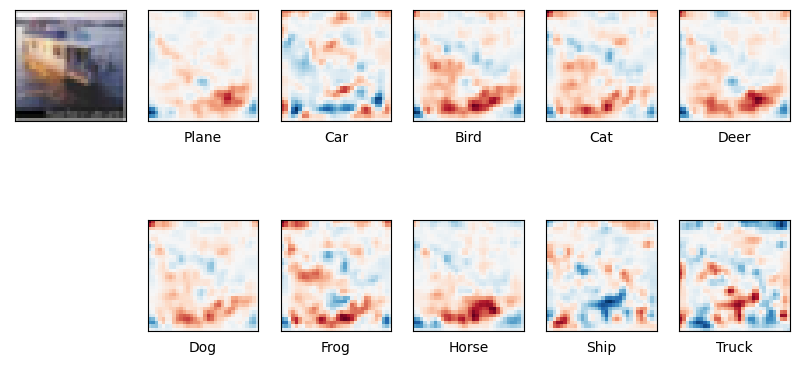

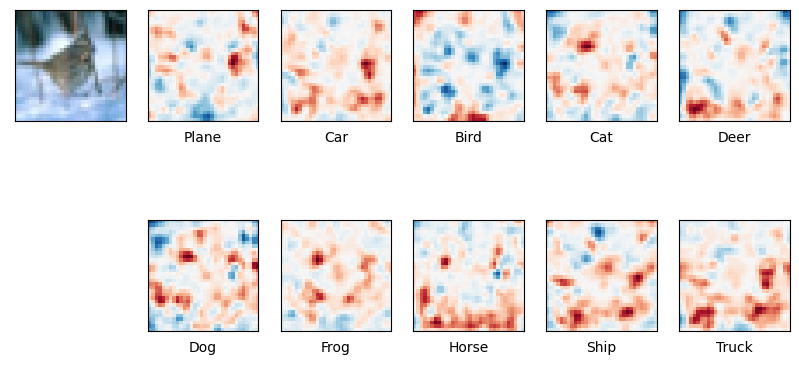

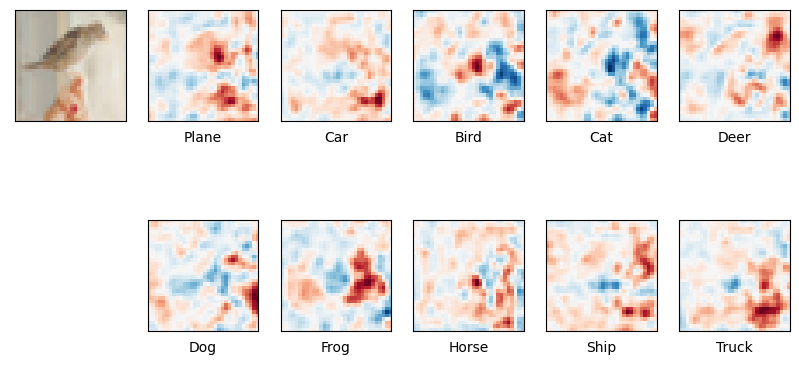

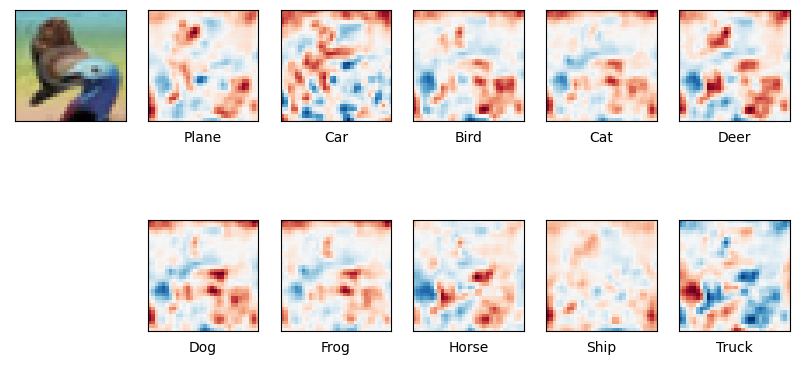

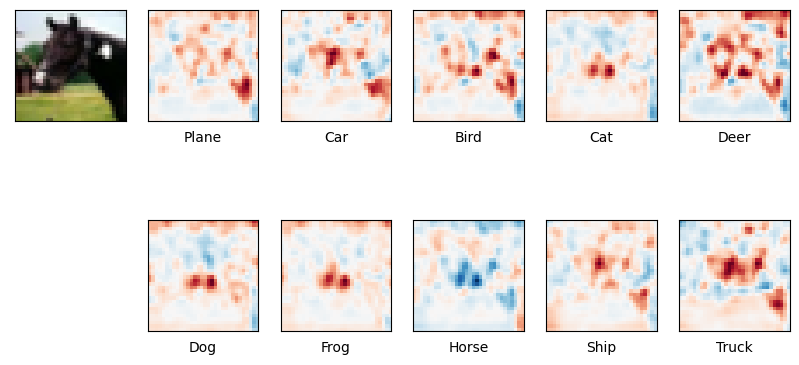

In [13]:
app(
    cifar_predict_arr,
    cifar10_classifier,
    gen_sliding_window,
    results_filepath = "high_level.pkl"
)

### Low-Level API Integration <a name="low-level-api-integration"></a>

#### Defining `LitSaliencyModel` <a name="defining-lit-saliency-model"></a>

Here we will define `LitSaliencyModel` which overrides the `predict_step` function of `LitModel` to add saliency map generation for each image that we predict on. The "driver" of this added functionality is `gen_saliency_maps(ref_preds, imgs)`.

To generate saliency maps, we'll need a pertubation implementation and a saliency generator.

Within `gen_saliency_maps(..)`, there are 3 main steps:
1. Generate perturbed data via the perturber
2. Predict upon the perturbed data
3. Using these prediction results, the saliency generator will generate heat maps

**Note:** When integrated within PyTorch Lightning like this or in a similar manner, saliency map operations take place on pre-processed tensors instead of raw input images. Certain details may need to be adjusted compared to a high-level integration. For example, here we won't explicitly set a fill value because our data will be pre-processed such that the grey value would be zeros.

In [14]:
class LitSaliencyModel(LitModel):
    def __init__(
        self, 
        channels, 
        width, 
        height, 
        num_classes,
        perturber: PerturbImage,
        saliency_generator: GenerateClassifierConfidenceSaliency,
        labels: Sequence[Hashable]=[],
        hidden_size=64, 
        learning_rate=2e-4,
        process = 'batch',
        threads: int=4,
        display_results = True,
        results_filepath = None
    ):
        super().__init__(
            channels, 
            width, 
            height, 
            num_classes,
            hidden_size, 
            learning_rate,
        )

        self.perturber = perturber
        self.generator = saliency_generator
        self.labels = labels
        if not self.labels:
            self.labels = list(range(self.num_classes))
            
        self.process = process
        self.threads = threads
        # Optional fill color
        self.fill: Optional[Union[int, Sequence[int]]] = None
        self.display_results = display_results
        self.results_filepath = results_filepath
        
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        if isinstance(batch, list):
            x, _ = batch
        else:
            x = batch

        preds = super().predict_step(x, batch_idx, dataloader_idx)
        
        # Generate saliency maps for every input
        self._gen_saliency_maps(preds, x)
        
        return preds
    
    def _gen_saliency_maps(
        self,
        ref_preds: Any,
        imgs: Any
    ) -> None:
        sal_maps_set = []
        ref_imgs = []
        for ref_pred, img in zip(ref_preds, imgs):
            # Lightning data is channel first
            ref_img = np.moveaxis(img.cpu().data.numpy(), 0, 2)
            ref_imgs.append(ref_img)

            # Generate pertubation masks
            pert_masks = self.perturber(ref_img)

            # Confidence value setup
            ref_conf_dict = list(self._classify_preds([[ref_pred]]))[0]
            ref_conf_vec = np.asarray([ref_conf_dict[la] for la in self.labels])
            pert_conf_mat = np.empty(
                (pert_masks.shape[0], ref_conf_vec.shape[0]),
                dtype=ref_conf_vec.dtype
            )

            # Generate perturbed images
            pert_imgs_it = self._gen_perturbed_imgs(ref_img, pert_masks)

            # Predict on perturbed images
            pert_outputs = []
            dataloader = DataLoader(
                 self._MaskDataset(pert_imgs_it, imgs),
                 shuffle=False,
                 batch_size = BATCH_SIZE
             )
            for batch in dataloader:
                pert_outputs.append(F.softmax(self(batch), dim=1))
            pert_conf_it = self._classify_preds(pert_outputs)

            # Format confidence values for generator
            for i, pc in enumerate(pert_conf_it):
                pert_conf_mat[i] = [pc[la] for la in self.labels]

            # Generate saliency map
            sal_maps_set.append(
                self.generator(
                    ref_conf_vec,
                    pert_conf_mat,
                    pert_masks,
            ))
            
        # Save saliency map for comparison for examples sake
        # Could be replaced by artifact tracking
        if self.results_filepath is not None:
            pickle.dump(sal_maps_set, open(self.results_filepath, "wb"))
                
        # Plot each image in set with saliency maps
        if self.display_results:
            self._plot_saliency_maps(sal_maps_set, ref_imgs)
    
    class _MaskDataset(Dataset):
        def __init__(self, imgs, ref_tensor = None):
            self.imgs = imgs
            self.to_tensor = transforms.ToTensor()
            self.ref_tensor = ref_tensor
            
        def __len__(self):
            return len(self.imgs)
        
        def __getitem__(self, index):
            img = self.to_tensor(self.imgs[index])
            if self.ref_tensor is not None:
                img = img.type_as(self.ref_tensor)
            return img
        
    def _gen_perturbed_imgs(self, ref_img, pert_masks):
        if self.process == "stream":
            pert_imgs_it = occlude_image_streaming(
                ref_img, 
                pert_masks,
                fill = self.fill,
                threads = self.threads
            )
        elif self.process == "batch":
            pert_imgs_it = occlude_image_batch(
                ref_img, 
                pert_masks,
                fill = self.fill,
                threads = self.threads
            )
        else:
            raise ValueError(f"Unknown generate perturbed images process type: {self.process}")
        
        return pert_imgs_it
    
    def _classify_preds(self, preds):
        results = []
        for batch in preds:
            for pred in batch:
                r = {}
                for p, la in zip(pred, self.labels):
                    r[la] = np.float32(p.item())
                results.append(r)
            
        return results
    
    def _plot_saliency_maps(self, sal_maps_set, ref_imgs):
        for i in range(len(sal_maps_set)):
            plt.figure(figsize=(10,5))
            num_cols = np.ceil(self.num_classes/2).astype(int) + 1
            plt.subplot(2, num_cols, 1)
            plt.imshow((ref_imgs[i]+1)/2, cmap='gray')
            plt.xticks(())
            plt.yticks(())

            for c in range(num_cols - 1):
                plt.subplot(2, num_cols, c + 2)
                plt.imshow(sal_maps_set[i][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
                plt.xticks(())
                plt.yticks(())
                plt.xlabel(f"{self.labels[c]}")
            for c in range(self.num_classes - num_cols + 1, self.num_classes):
                plt.subplot(2, num_cols, c + 3)
                plt.imshow(sal_maps_set[i][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
                plt.xticks(())
                plt.yticks(())
                plt.xlabel(f"{self.labels[c]}")

#### Perturber and Saliency Generator <a name="perturber-and-saliency-generator"></a>

We create an instance of `SlidingWindow`, an implementation of the `PerturbImage` interface, to carry out our image pertubation and an instance of `OcclusionScoring`, an implementation of the `GenerateClassifierConfidenceSaliency` interface, for heatmap generation.

In [15]:
sliding_window_perturber = SlidingWindow(
    window_size=(2, 2),
    stride=(1, 1),
)
sal_map_generator = OcclusionScoring()

#### Generate Saliency Maps <a name="generate-saliency-maps"></a>

With our new `LitSaliencyModel`, we just have to call predict on our trained model to generate saliency maps across all predicted images. We'll load weights from our saved checkpoint so we don't need to train again.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at cifar10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar10.ckpt
/home/local/KHQ/emily.veenhuis/.conda/envs/torch-test-env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

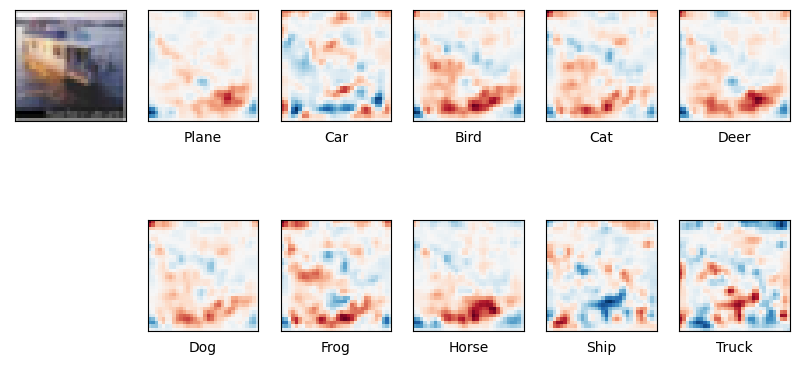

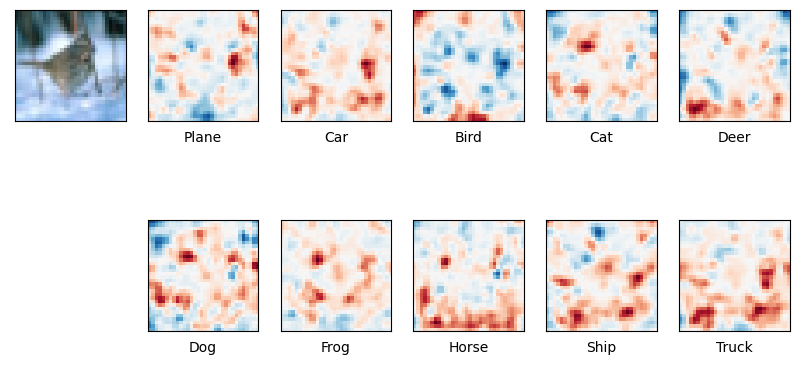

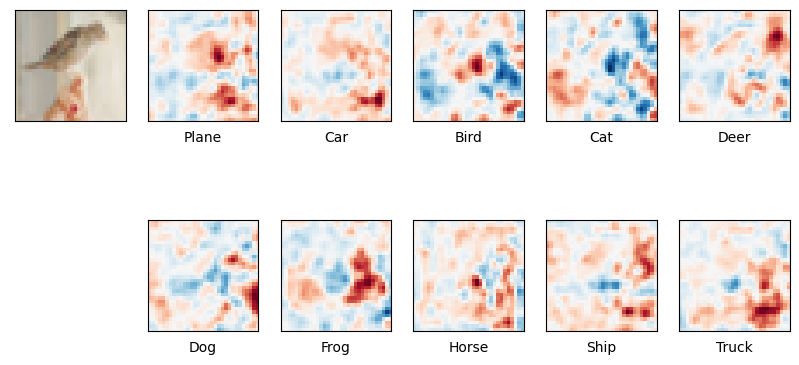

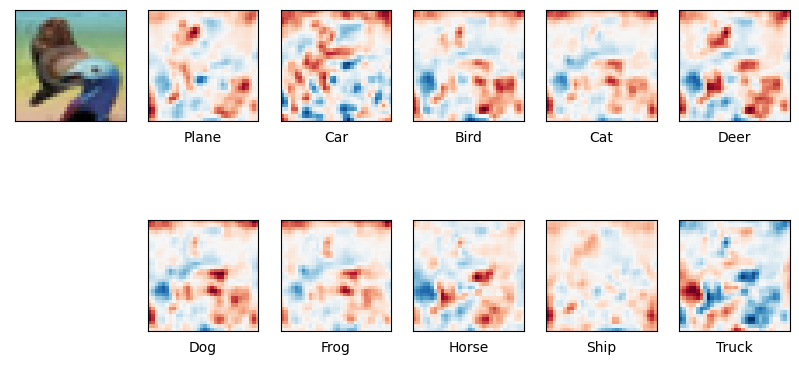

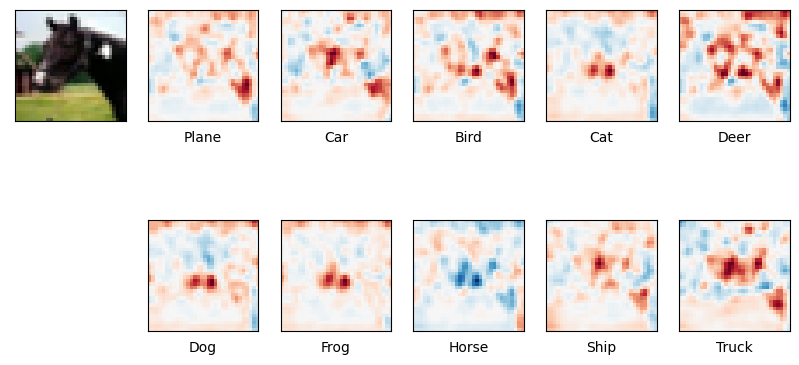

In [16]:
cifar10_model_low_level = LitSaliencyModel.load_from_checkpoint(
    perturber=sliding_window_perturber,
    saliency_generator=sal_map_generator,
    labels=cifar10_dm.get_classes(),
    results_filepath="low_level.pkl",
    checkpoint_path=CHKPT_PATH
)
cifar10_trainer_low_level = Trainer(
    max_epochs=5,
    accelerator="auto",
    # NOTE: Limiting devices here so we can compare results more easily
    devices=1 if torch.cuda.is_available() else "auto",
    callbacks=[tqdm_progress_bar],
)
preds = cifar10_trainer_low_level.predict(model=cifar10_model_low_level, datamodule=cifar10_dm, ckpt_path=CHKPT_PATH)

### Results Comparison <a name="results-comparison"></a>

We can see via visual inspection that the saliency maps produced are consistent across both the high- and low-level methods, as expected. We can also confirm this numerically:

In [17]:
low_level = pickle.load(open("low_level.pkl", "rb"))
high_level = pickle.load(open("high_level.pkl", "rb"))

allclose = [True]*len(low_level)
for idx, compare in enumerate(zip(low_level, high_level)):
    for l, h in zip(compare[0], compare[1]):
        # Normalize data
        l = (l-np.min(l))/(np.max(l)-np.min(l))
        h = (h-np.min(h))/(np.max(h)-np.min(h))

        if not np.allclose(l, h, atol=1e-02):
            allclose[idx] = False
            break
print(allclose)
assert(all(allclose))

[True, True, True, True, True]
